## PASCAL-VOC Detection model Training and Inference

In this notebook we will use axelerate, Keras-based framework for AI on the edge, to quickly setup model training and then after training session is completed convert it to .tflite and .kmodel formats.

First, let's take care of some administrative details.

1) Before we do anything, make sure you have choosen GPU as Runtime type (in Runtime - > Change Runtime type).

2) We need to mount Google Drive for saving our model checkpoints and final converted model(s). Press on Mount Google Drive button in Files tab on your left.

In the next cell we clone axelerate Github repository and import it.

**It is possible to use pip install or python setup.py install, but in that case you will need to restart the enironment.** Since I'm trying to make the process as streamlined as possibile I'm using sys.path.append for import.

In [1]:
#we need imgaug 0.4 for image augmentations to work properly, see https://stackoverflow.com/questions/62580797/in-colab-doing-image-data-augmentation-with-imgaug-is-not-working-as-intended
#!pip uninstall -y imgaug && pip uninstall -y albumentations && pip install imgaug==0.4
#!git clone https://github.com/damiantomczyszyn/aXeleRate.git
import sys
#sys.path.append('/content/aXeleRate')


In [2]:
append = !pwd

In [3]:
append2 = str(append)+'/content/aXeleRate'
append2 = append2.replace('[', '')
append2 = append2.replace(']', '')
append2 = append2.replace("'", '')
print(append2)


/home/damian/Desktop/python-venv/MaixduinoAI/training/content/aXeleRate


In [4]:
import sys
sys.path.append(append2)

In [5]:
from axelerate import setup_training, setup_inference, setup_evaluation

2024-03-06 15:21:40.099088: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 15:21:40.099151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 15:21:40.172116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 15:21:40.326846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 15:21:41.329056: W tensorflow/compiler/tf2

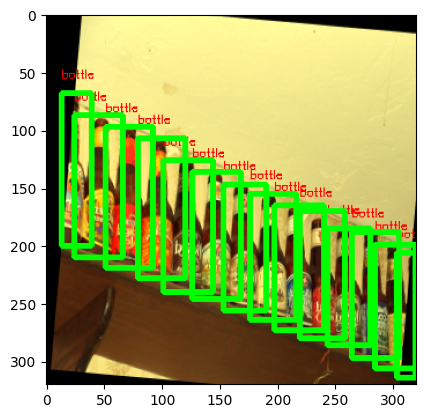

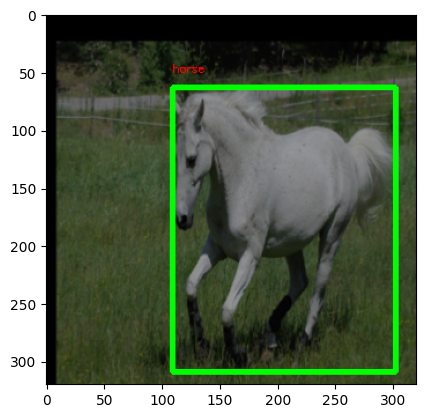

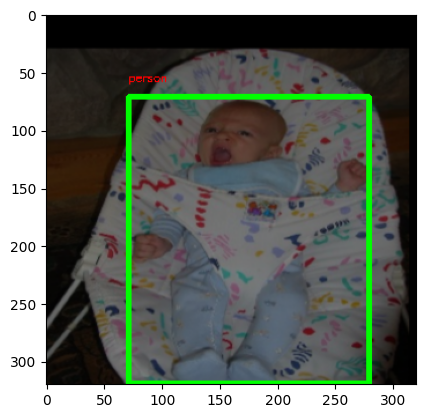

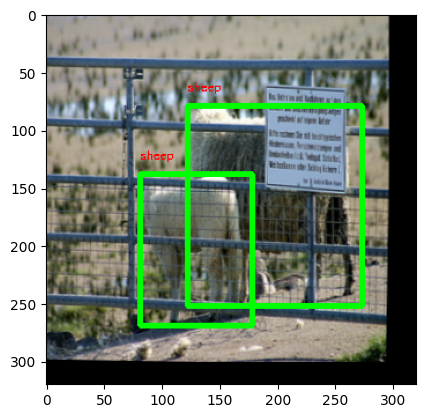

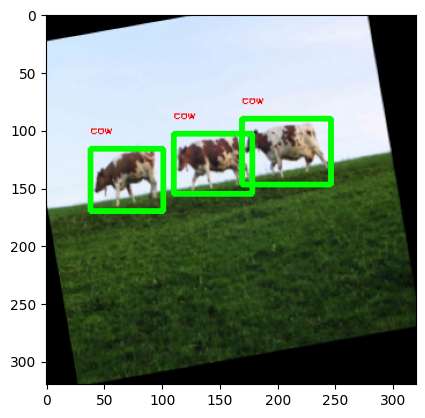

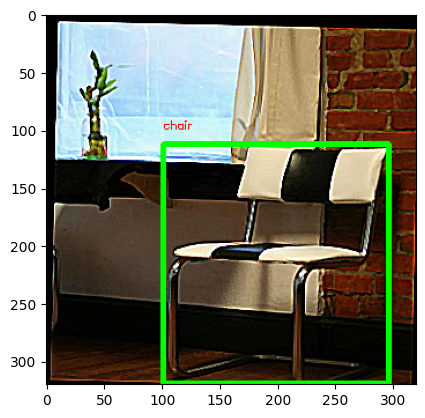

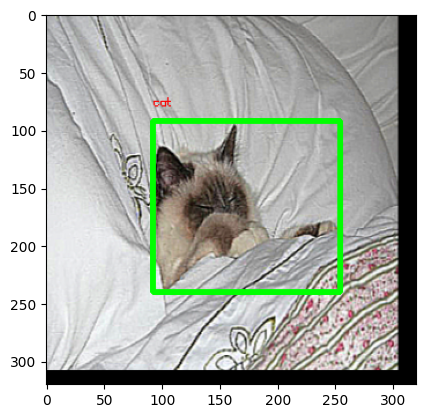

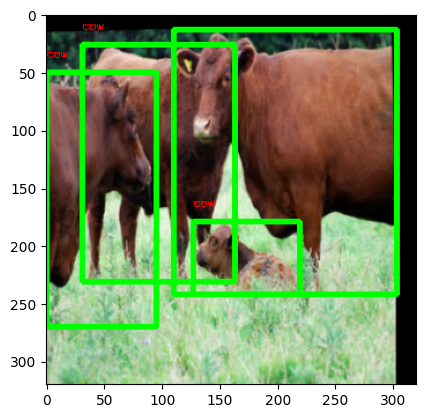

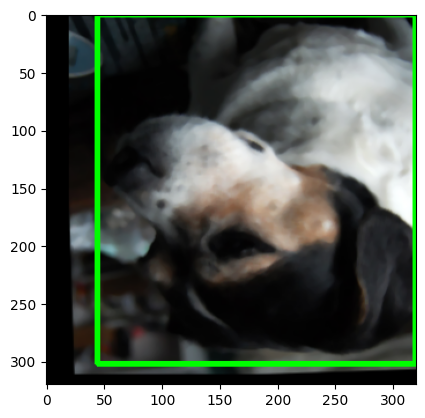

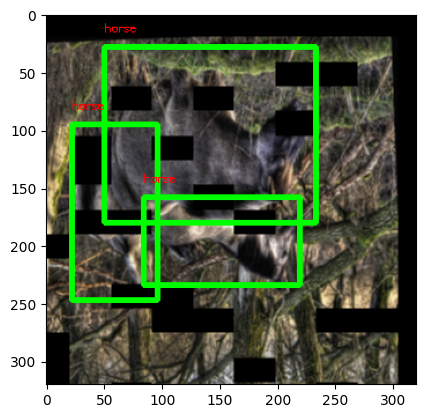

In [6]:
%matplotlib inline
#!gdown https://drive.google.com/uc?id=1xgk7svdjBiEyzyUVoZrCz4PP6dSjVL8S  #pascal-voc dataset
#!gdown https://drive.google.com/uc?id=1-2jYfTRPX4kSUTL5SUQVxwHKjBclrBTA  #pre-trained model
#!unzip --qq pascal_20_detection.zip

from axelerate.networks.common_utils.augment import visualize_detection_dataset as vdd

vdd(img_folder='pascal_20_detection/imgs_validation', ann_folder='pascal_20_detection/anns_validation', num_imgs=10, img_size=320, augment=True)




In [7]:
import tensorflow as tf


In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-03-06 15:21:54.939464: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 15:21:55.216688: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 15:21:55.216877: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15736673613325242514
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10078781440
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16948078441165651648
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:0a:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

Also, let's open Tensorboard, where we will be able to watch model training progress in real time. Training and validation logs also will be saved in project folder.
Since there are no logs before we start the training, tensorboard will be empty. Refresh it after first epoch.

In [9]:
%load_ext tensorboard
%tensorboard --logdir logs
!sleep 5

Finally we start the training by passing config dictionary we have defined earlier to setup_training function. The function will start the training with  Reduce Learning Rate on Plateau and save on best mAP callbacks. Every epoch mAP of the model predictions is measured on the validation dataset. If you have specified the converter type in the config, after the training has stopped the script will convert the best model into the format you have specified in config and save it to the project folder.

Let's train for one epoch to see how the whole pipeline works.

In [10]:
#from keras import backend as K
#K.clear_session()
#model_path = setup_training(config_dict=config)

After training it is good to check the actual perfomance of your model by doing inference on your validation dataset and visualizing results. This is exactly what next block does. Our model used pre-trained weights and since all the layers were set as non-trainable, we are just observing the perfomance of the model that was trained before.

In [11]:
#%matplotlib inline
#from keras import backend as K
#K.clear_session()
#setup_inference(config, model_path)

If you need to convert trained model to other formats, for example for inference with Edge TPU or OpenCV AI Kit, you can do it with following commands. Specify the converter type, backend and folder with calbiration images(normally your validation image folder).

In [12]:
#from axelerate.networks.common_utils.convert import Converter
#converter = Converter('tflite_dynamic', 'MobileNet1_0', 'pascal_20_detection/imgs_validation')
#converter.convert_model(model_path)

To train the model from scratch use the following config and then run the cells with training and (optinally) inference functions again.

In [13]:
config = {
        "model":{
            "type":                 "Detector",
            "architecture":         "MobileNet1_0",
            "input_size":           [224, 320],
            "anchors":              [[[0.76120044, 0.57155991], [0.6923348, 0.88535553], [0.47163042, 0.34163313]],
                                    [[0.33340788, 0.70065861], [0.18124964, 0.38986752], [0.08497349, 0.1527057 ]]],
            "labels":               ["person", "bird", "cat", "cow", "dog", "horse", "sheep", "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train","bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"],
            "obj_thresh" : 		    0.7,
            "iou_thresh" : 		    0.5,
            "coord_scale" : 		  1.0,
            "object_scale" : 		  3.0,
            "no_object_scale" : 	1.0
        },
        "weights" : {
            "full":   				  "",
            "backend":   		    "imagenet"
        },
        "train" : {
            "actual_epoch":         1000,
            "train_image_folder":   "pascal_20_detection/imgs",
            "train_annot_folder":   "pascal_20_detection/anns",
            "train_times":          1,
            "valid_image_folder":   "pascal_20_detection/imgs_validation",
            "valid_annot_folder":   "pascal_20_detection/anns_validation",
            "valid_times":          1,
            "valid_metric":         "recall",
            "batch_size":           32,
            "learning_rate":        1e-3,
            "saved_folder":   		F"/home/damian/Desktop/python-venv/MaixduinoAI/training/content/model",
            "first_trainable_layer": "",
            "augmentation":				  True,
            "is_only_detect" : 		  False
        },
        "converter" : {
            "type":   				[]
        }
}

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


2024-03-06 15:22:02.961347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 15:22:02.961647: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 15:22:02.961863: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
from keras import backend as K
K.clear_session()
model_path = setup_training(config_dict=config)

Project folder /home/damian/Desktop/python-venv/MaixduinoAI/training/content/model already exists. Creating a folder for new training session.
['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']


2024-03-06 15:22:02.994511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 15:22:02.994813: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 15:22:02.995036: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Successfully loaded imagenet backend weights
Failed to load pre-trained weights for the whole model. It might be because you didn't specify any or the weight file cannot be found


/home/damian/Desktop/python-venv/MaixduinoAI/training/content/aXeleRate/axelerate/networks/yolo/backend/loss.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(grid)


pascal_20_detection/anns_validation
Current training session folder is /home/damian/Desktop/python-venv/MaixduinoAI/training/content/model/2024-03-06_15-22-09


[<axelerate.networks.yolo.backend.utils.custom.Yolo_Precision object at 0x7f2e04454310>, <axelerate.networks.yolo.backend.utils.custom.Yolo_Recall object at 0x7f2e0458c950>]
Model: "yolo"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 226, 322, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1 (Conv2D)              (None, 112, 160, 32)        

2024-03-06 15:22:09.941577: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/1000


2024-03-06 15:22:21.838527: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 15:22:22.272591: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


532/532 [==============================] - ETA: 0s - loss: 137.2612 - reshape_loss: 34.6530 - reshape_1_loss: 102.6083 - reshape_precision: 0.0587 - reshape_recall: 6.5390e-04 - reshape_1_precision: 0.0587 - reshape_1_recall: 6.5305e-04

total_val_recall: 0.0070
Saving model on first epoch irrespective of total_val_recall
Epoch 00000: Learning rate is 0.00033270676691729323.



/home/damian/Desktop/python-venv/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


532/532 [==============================] - 92s 138ms/step - loss: 137.2612 - reshape_loss: 34.6530 - reshape_1_loss: 102.6083 - reshape_precision: 0.0587 - reshape_recall: 6.5390e-04 - reshape_1_precision: 0.0587 - reshape_1_recall: 6.5305e-04 - val_loss: 28.1746 - val_reshape_loss: 12.2367 - val_reshape_1_loss: 15.9379 - val_reshape_precision: 0.2898 - val_reshape_recall: 0.0071 - val_reshape_1_precision: 0.2898 - val_reshape_1_recall: 0.0070 - total_val_recall: 0.0070
Epoch 2/1000
532/532 [==============================] - ETA: 0s - loss: 36.5217 - reshape_loss: 10.1566 - reshape_1_loss: 26.3651 - reshape_precision: 0.2553 - reshape_recall: 0.0279 - reshape_1_precision: 0.2553 - reshape_1_recall: 0.0279

total_val_recall: 0.0447
total_val_recall improved from 0 to 0.044717658311128616, saving model to /home/damian/Desktop/python-venv/MaixduinoAI/training/content/model/2024-03-06_15-22-09/yolo_best_recall.h5.
Epoch 00001: Learning rate is 0.0006660401002506265.

532/532 [=============

In [ ]:
%matplotlib inline
from keras import backend as K
K.clear_session()
setup_inference(config, model_path)

Good luck and happy training! Have a look at these articles, that would allow you to get the most of Google Colab or connect to local runtime if there are no GPUs available;

https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403

https://research.google.com/colaboratory/local-runtimes.html